# PREPROCESSING

ATTENTION-LSTM Forecasting with VMD Decomposition on ETTh1 Dataset

In this experiment, we use the ETTh1 dataset (Electricity Transformer Temperature, hourly data) to forecast the oil temperature (OT).
We first apply **Variational Mode Decomposition (VMD)** to extract intrinsic mode components (IMFs) from the `OT` series, 
then use an **Attention-based LSTM (Attn-LSTM)** to capture temporal dependencies and focus on informative time steps.



## Import-Params-Read-Visualization

In [7]:
# Parameters
SEQ_LEN = 168 # past 7 days(7*24) for each sample
TARGET_COL = 'OT'  # target variable: Oil Temperature
EPOCHS = 50 
BATCH_SIZE = 32

# VMD parameters
DC = 0              # no DC part imposed
init = 1            # initialize omegas uniformly
tol = 1e-7
K = 12                  # number of VMD modes (tuneable)
alpha = 1705             # VMD alpha (tuneable)
tau = 0.05805898025979961                # VMD tau

LSTM_UNITS = 128
DROPOUT = 0.2
LEARNING_RATE = 1e-3

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Softmax
from vmdpy import VMD
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Lambda, Input, LSTM, Dense, Dropout,Bidirectional, Layer,LayerNormalization
from tensorflow.keras.optimizers import Adam
import random
import keras
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    mode="min",
    patience=50,
    restore_best_weights=True,
    verbose=1
)


In [3]:
save_dir = os.path.expanduser("~/Project/AtLSTM_VMD/data/raw")
os.makedirs(save_dir, exist_ok=True)
# Full file path
file_path = os.path.join(save_dir, "ETTh1.csv")
# Load it whenever needed
df = pd.read_csv(file_path)
print(df.head())
df.columns = df.columns.str.strip().str.replace('\ufeff', '')
print(df.columns)
# Ensure datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
data = df[[TARGET_COL]].values


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


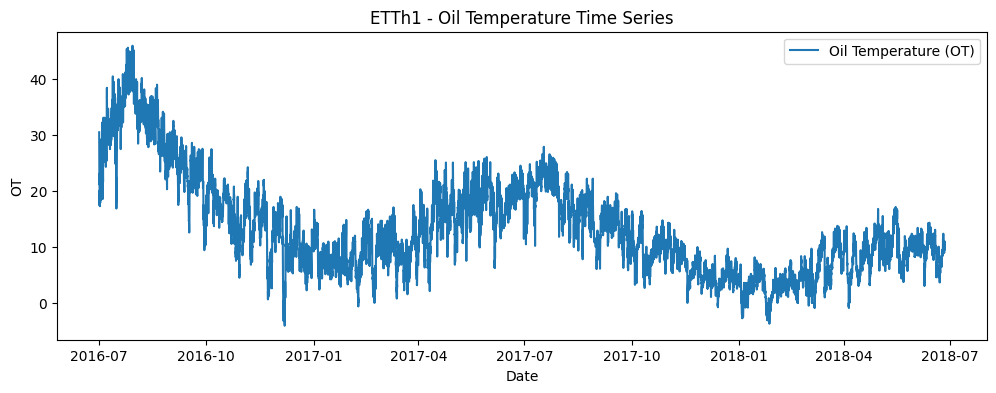

In [4]:
# Visualize
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['OT'], label='Oil Temperature (OT)')
plt.title('ETTh1 - Oil Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

## X,Y  and Train_test_split one feature

In [5]:
# =====================================================
# Split Train/Test
# =====================================================
split_idx = int(len(df) * 0.8)
train_data = df[:split_idx]
test_data  = df[split_idx:]
# =====================================================
# Helper for VMD-based training data
# =====================================================
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    limit = min(len(X), len(y)) - seq_len
    for i in range(limit):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

    

u_train, _, _ = VMD(train_data[TARGET_COL].values, alpha, tau, K, DC=0, init=1, tol=1e-7)
u_test,  _, _ = VMD(test_data[TARGET_COL].values,  alpha, tau, K, DC=0, init=1, tol=1e-7)

vmd_train = np.stack(u_train, axis=1)
vmd_test  = np.stack(u_test,  axis=1)

# --- Scale features & target ---
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_scaled_vmd = scaler_x.fit_transform(vmd_train)
train_scaled_target = scaler_y.fit_transform(train_data[[TARGET_COL]])
test_scaled_vmd  = scaler_x.transform(vmd_test)
test_scaled_target  = scaler_y.transform(test_data[[TARGET_COL]])

# --- Sequence generation (aligned) ---
X_train_vmd, y_train_vmd = create_sequences(train_scaled_vmd, train_scaled_target, SEQ_LEN)
X_test_vmd,  y_test_vmd  = create_sequences(test_scaled_vmd,  test_scaled_target,  SEQ_LEN)
X_train_simple, y_train_simple = create_sequences(train_scaled_target,train_scaled_target,SEQ_LEN)
X_test_simple, y_test_simple = create_sequences(test_scaled_target,test_scaled_target,SEQ_LEN)
y_test_simple_true = scaler_y.inverse_transform(y_test_simple.reshape(-1, 1)).flatten()
y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd)

## CUSTOM LAYERS

In [6]:
# ===================================================
# PERFORMER ATTENTION
# ===================================================
class PerformerAttention(Layer):
    def __init__(self, num_heads, model_dim, kernel_eps=1e-6, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.kernel_eps = kernel_eps
        self.dropout = Dropout(dropout)
        self.head_dim = model_dim // num_heads
        assert model_dim % num_heads == 0, "model_dim must be divisible by num_heads"

    def build(self, input_shape):
        # Linear projections
        self.Wq = Dense(self.model_dim)
        self.Wk = Dense(self.model_dim)
        self.Wv = Dense(self.model_dim)
        self.Wo = Dense(self.model_dim)
        
        # Random Gaussian projection for FAVOR+
        self.proj = self.add_weight(
            shape=(self.head_dim, self.head_dim),
            initializer="random_normal",
            trainable=False,
            name="proj_matrix"
        )

    def kernel(self, x):
        # FAVOR+ kernel Φ(x)
        x_proj = tf.einsum("...nd,df->...nf", x, self.proj)
        return tf.nn.relu(x_proj) + self.kernel_eps

    def split_heads(self, x):
        B = tf.shape(x)[0]
        T = tf.shape(x)[1]
        x = tf.reshape(x, (B, T, self.num_heads, self.head_dim))
        return tf.transpose(x, [0, 2, 1, 3])  # (B, H, T, Dh)

    def merge_heads(self, x):
        B = tf.shape(x)[0]
        T = tf.shape(x)[2]
        x = tf.transpose(x, [0, 2, 1, 3])
        return tf.reshape(x, (B, T, self.model_dim))

    def call(self, x, training=False):
        Q, K, V = x  # all shape (B, T, model_dim)
        
        # Linear projections + split heads
        Q = self.split_heads(self.Wq(Q))
        K = self.split_heads(self.Wk(K))
        V = self.split_heads(self.Wv(V))
        
        # FAVOR+ kernel
        Q_phi = self.kernel(Q)  # (B, H, T, Dh)
        K_phi = self.kernel(K)
        
        # Compute KV and normalization
        KV = tf.einsum("bhnd,bhne->bhde", K_phi, V)  # (B,H,Dh,Dh)
        Z = 1.0 / (tf.einsum("bhnd,bhd->bhn", Q_phi, tf.reduce_sum(K_phi, axis=2)) + 1e-6)
        out = tf.einsum("bhnd,bhde,bhn->bhne", Q_phi, KV, Z)
        
        # Merge heads
        out = self.merge_heads(out)
        return self.Wo(out)
# =====================================================
# 2️⃣ Bahdanau-style Attention Layer
# =====================================================
class AttentionLayer_Bahdanau(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer_Bahdanau, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True,
            name="att_weight"
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
            name="att_bias"
        )
        self.u = self.add_weight(
            shape=(input_shape[-1],),
            initializer="glorot_uniform",
            trainable=True,
            name="context_vector"
        )
        super(AttentionLayer_Bahdanau, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, time_steps, features)
        u_it = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)   # (batch, time, features)
        a_it = tf.tensordot(u_it, self.u, axes=1)                  # (batch, time)
        a_it = tf.nn.softmax(a_it, axis=1)                         # (batch, time)
        a_it = tf.expand_dims(a_it, axis=-1)                       # (batch, time, 1)
        weighted_output = x * a_it                                  # (batch, time, features)
        return tf.reduce_sum(weighted_output, axis=1)              # (batch, features)

    def compute_output_shape(self, input_shape):
        # output shape: (batch, features)
        return (input_shape[0], input_shape[2])


def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model

# ========================================
# 📌     LSTM + Residual Connection + LayerNorm
# ========================================
class LSTM_residual_norm(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(LSTM_residual_norm, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]    # <-- Detect feature count automatically

        # Projection for residual connection
        self.proj = Dense(self.units)  # input_dim → units

        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)

        h_res = self.proj(x)   # Now works for any feature dimension

        return self.norm(h + h_res)

# ========================================
# 📌  Attention(Bahdanau) + LSTM + Residual Connection + LayerNorm
# ========================================
def build_att_customlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM_residual_norm(lstm1_units)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM_residual_norm(lstm2_units)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model
    
# =========================================================
# 📌  Custom Luong Attention
# score = h_t · W · h_s  (dot-product)
# =========================================================
class LuongAttention(Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.Wq = Dense(units)
        self.Wv = Dense(units)

    def call(self, query, value, mask=None):
        # Project both → SAME dimension
        q = self.Wq(query)      # (B, T, units)
        v = self.Wv(value)      # (B, T, units)

        # Dot product score
        score = tf.matmul(q, v, transpose_b=True)  # (B, T, T)

        if mask is not None:
            score += (mask * -1e9)

        # Use tf.nn.softmax (Keras-safe)
        attn_weights = tf.nn.softmax(score, axis=-1)     # (B, T, T)
        context = tf.matmul(attn_weights, v)             # (B, T, units)

        return context

# =========================================================
# 📌  Temporal Attention (per timestep)
# =========================================================
class TemporalAttention(Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # input_shape = (batch, timesteps, features)
        d = input_shape[-1]

        self.Wt = Dense(self.units, activation='tanh')
        self.vt = Dense(1)

    def call(self, x):
        # score shape -> (batch, timesteps, units)
        h = self.Wt(x)

        # score shape -> (batch, timesteps, 1)
        score = self.vt(h)

        # attention weights
        alpha = tf.nn.softmax(score, axis=1)

        # weighted sum (batch, timesteps, features) -> (batch, features)
        context = tf.reduce_sum(alpha * x, axis=1)

        return context
        
def build_Tattlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):

    inp = Input(shape=input_shape)

    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)

    # Temporal Attention
    att_out = TemporalAttention(units=lstm1_units)(x)

    # Decoder LSTM - convert context vector to sequence again
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)

    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model
# =========================================================
# 📌  Cross-Attention (Query from XLSTM, Key/Value from VMD input)
# =========================================================
class CrossAttention(Layer):
    def __init__(self, num_heads=4, key_dim=32):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, query, context, mask=None):
        return self.mha(query=query, value=context, key=context, attention_mask=mask)


# =========================================================
# 📌  Causal Masking (prevent future leakage)
# =========================================================
def causal_mask(seq_len):
    mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask[None, None, :, :]



# =========================================================
# 📌  TFT Multi-Head Temporal self-Attention Layer (Keras)
#     this is a valid implementation of the temporal self-attention block inspired by the TFT paper:
#     Multi-head scaled dot-product attention
#     Decoder state as query
#     Encoder outputs as key/value
#     Layer norm + residual
#     Optional causal masking
#     It is simplified (no gating via GRN or VSN), but the attention math is correct and aligned with Transformer/TFT definitions.
# ========================================================= 
class TFTTemporalAttention(Layer):
    def __init__(self, num_heads, model_dim, dropout_rate=0.1,
                 use_mask=False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.dropout_rate = dropout_rate
        self.use_mask = use_mask
        
        assert model_dim % num_heads == 0
        self.head_dim = model_dim // num_heads

        self.Wq = Dense(model_dim)
        self.Wk = Dense(model_dim)
        self.Wv = Dense(model_dim)
        self.Wo = Dense(model_dim)

        self.layernorm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)

    def build(self, input_shape):
        self.Wq.build(input_shape[0])
        self.Wk.build(input_shape[0])
        self.Wv.build(input_shape[0])
        self.Wo.build((None, None, self.model_dim))
        self.layernorm.build((None, None, self.model_dim))
        self.built = True

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1,
                           self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=None):
        encoder_out, decoder_state = inputs

        batch_size = tf.shape(encoder_out)[0]

        dec_expanded = tf.repeat(
            tf.expand_dims(decoder_state, axis=1),
            repeats=tf.shape(encoder_out)[1],
            axis=1
        )

        Q = self.Wq(dec_expanded)
        K = self.Wk(encoder_out)
        V = self.Wv(encoder_out)

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.cast(tf.sqrt(float(self.head_dim)), tf.float32)
        score = score / scale

        if self.use_mask:
            T = tf.shape(encoder_out)[1]
            mask = tf.linalg.band_part(tf.ones((T, T)), -1, 0)
            mask = 1e-9 * (1 - mask)
            score += mask

        alpha = tf.nn.softmax(score, axis=-1)
        att_out = tf.matmul(alpha, V)

        att_out = tf.transpose(att_out, perm=[0, 2, 1, 3])
        att_out = tf.reshape(att_out,
                             (batch_size, -1, self.model_dim))

        out = self.Wo(att_out)

        # residual: input must have same dim
        out = self.layernorm(out)

        return out




def build_TFTattlstm_model(input_shape, lstm1_units=100, lstm2_units=100,
                             dense_units=32, num_heads=8, model_dim=128):

    # -------------------------
    # 0. Input
    # -------------------------
    encoder_inputs = Input(shape=input_shape)
    # -------------------------
    # 1. First LSTM Encoder
    # -------------------------
    enc_out = Bidirectional(LSTM(lstm1_units, return_sequences=True))(encoder_inputs)  # (batch, seq_len, 2*lstm1_units)
    enc_out = LayerNormalization()(enc_out)
    enc_out = Dense(model_dim)(enc_out)  
    enc_out = LayerNormalization()(enc_out)
    # -------------------------
    # 1b. Bahdanau Attention applied to LSTM output
    # -------------------------
    bahdanau_att = AttentionLayer_Bahdanau()(enc_out)
    bahdanau_att_exp = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att)

    # -------------------------
    # 2. Second LSTM Decoder
    # -------------------------
    dec_out = Bidirectional(LSTM(lstm2_units, return_sequences=False))(bahdanau_att_exp)
    dec_out = LayerNormalization()(dec_out)
    dec_out = Dense(model_dim)(dec_out) 
    dec_out = LayerNormalization()(dec_out)

    # -------------------------
    # 3. TFT Multi-Head Attention
    # -------------------------    
    att_layer = TFTTemporalAttention(
        num_heads=num_heads,
        model_dim=model_dim
    )
    att_out = att_layer([enc_out, dec_out])  # encoder_out, decoder_state

    # -------------------------
    # 5. Dense Output
    # -------------------------
    x = LSTM(dense_units)(att_out)
    output = Dense(1)(x)
    model = Model(encoder_inputs, output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model    


# AttLSTM+VMD

📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



I0000 00:00:1766772765.451811    4247 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21430 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 168, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 168, 132)       │        76,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 132)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau       │ (None, 132)            │        17,688 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,745 (948.22 KB)

 Trainable params: 242,745 (948.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1766772767.376954    4501 cuda_dnn.cc:529] Loaded cuDNN version 90300


431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0071 - mae: 0.0601 - val_loss: 0.0020 - val_mae: 0.0353
Epoch 2/50
  9/431 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0033 - mae: 0.0445

/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_mse available.
  if self._should_save_model(epoch, batch, logs, filepath):


431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0040 - mae: 0.0495 - val_loss: 0.0018 - val_mae: 0.0336
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0033 - mae: 0.0446 - val_loss: 0.0017 - val_mae: 0.0327
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0031 - mae: 0.0429 - val_loss: 0.0047 - val_mae: 0.0582
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0020 - mae: 0.0342 - val_loss: 0.0016 - val_mae: 0.0321
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0010 - mae: 0.0243 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 9.4176e-04 - mae: 0.0228 - val_loss: 7.4622e-04 - val_mae: 0.0219
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 6.8498e-04 - mae: 0.0195 - val_loss: 6.5820e-04 - val_mae: 0.0202
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 9.4150e-04 - mae: 0.0220 - val_loss: 4.9318e-04 - val_mae: 0.0173
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━

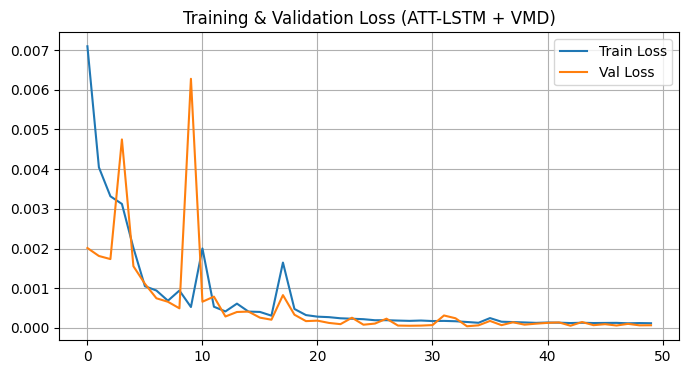

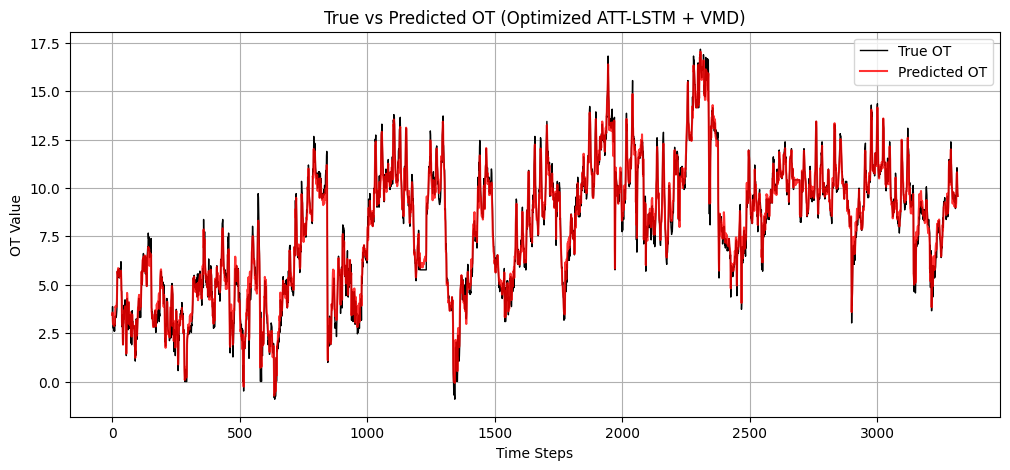

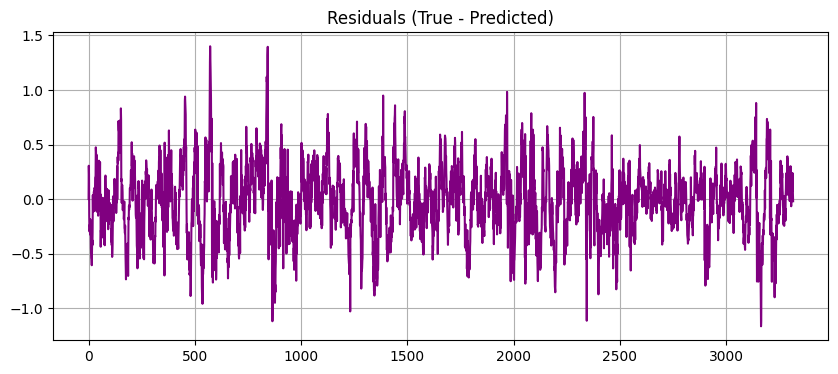

Total Area = 825.1889338665644
Area + = 385.38030567765315
Area - = -439.8086281889112


In [8]:
checkpoint_cb = ModelCheckpoint(
    filepath="best_attlstm_vmd.keras",
    monitor="val_mse",      
    mode="min",
    save_best_only=True,
    verbose=1
)

model_build_attlstm_model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_attlstm_model.summary()

history_attlstm_vmd = model_build_attlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1
)

# Predict and inverse-transform
y_pred_attlstm_vmd_scaled = model_build_attlstm_model.predict(X_test_vmd)
y_pred_attlstm_vmd_true = scaler_y.inverse_transform(y_pred_attlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_attlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true.squeeze() - y_pred_attlstm_vmd_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_vmd_true.squeeze() - y_pred_attlstm_vmd_true.squeeze()
area_total_attlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_attlstm_vmd)
area_positive_attlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_attlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_attlstm_vmd)
print("Area - =", area_negative_attlstm_vmd)

# TAttLSTM+VMD
Temporary Attention + lstm + vmd
📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 168, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 168, 132)       │        76,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 168, 132)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_attention_1            │ (None, 132)            │        17,689 │
│ (TemporalAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,746 (948.23 KB)

 Trainable params: 242,746 (948.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0075 - mae: 0.0621 - val_loss: 0.0022 - val_mae: 0.0370
Epoch 2/50
 11/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0041 - mae: 0.0496

/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_mse available.
  if self._should_save_model(epoch, batch, logs, filepath):


431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0043 - mae: 0.0509 - val_loss: 0.0022 - val_mae: 0.0369
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0034 - mae: 0.0453 - val_loss: 0.0027 - val_mae: 0.0422
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0024 - mae: 0.0376 - val_loss: 0.0019 - val_mae: 0.0333
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 0.0012 - val_mae: 0.0275
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 7.4105e-04 - mae: 0.0205 - val_loss: 6.1600e-04 - val_mae: 0.0197
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 6.4827e-04 - mae: 0.0189 - val_loss: 5.3178e-04 - val_mae: 0.0184
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 4.6273e-04 - mae: 0.0162 - val_loss: 3.4309e-04 - val_mae: 0.0146
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━

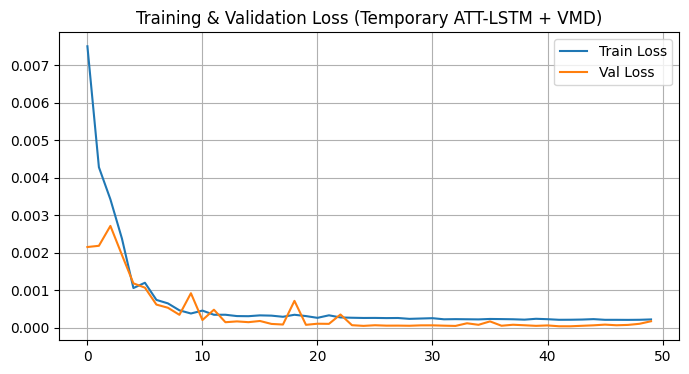

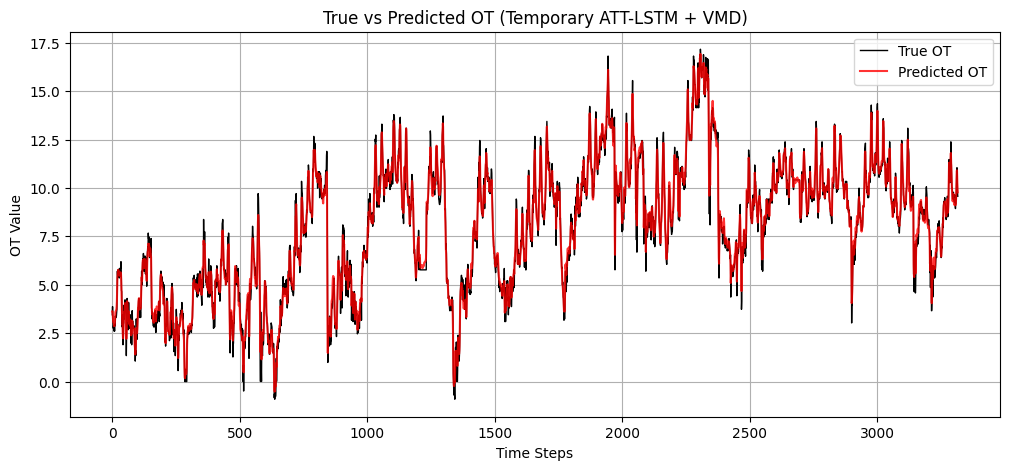

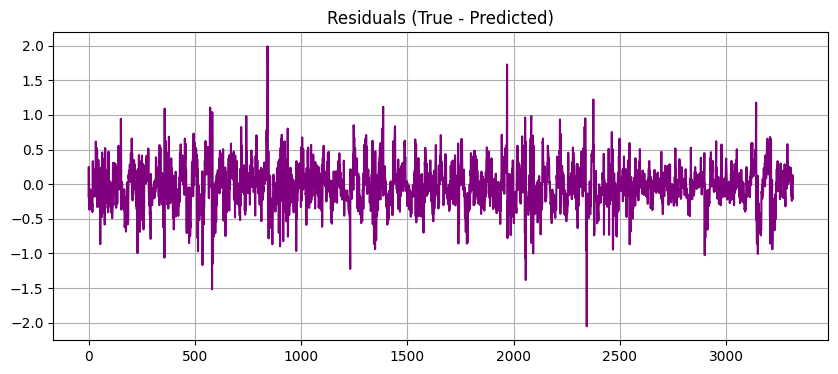

Total Area = 755.3798146657646
Area + = 340.0900311768062
Area - = -415.28978348895834


In [18]:
checkpoint_cb = ModelCheckpoint(
    filepath="best_Tattlstm_vmd.keras",
    monitor="val_mse",      
    mode="min",
    save_best_only=True,
    verbose=1
)


model_build_Tattlstm_model = build_Tattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_Tattlstm_model.summary()

history_Tattlstm_vmd = model_build_Tattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1
)


# Predict and inverse-transform
y_pred_Tattlstm_vmd_scaled = model_build_Tattlstm_model.predict(X_test_vmd)
y_pred_Tattlstm_vmd_true = scaler_y.inverse_transform(y_pred_Tattlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_Tattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_Tattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (Temporary ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_Tattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Temporary ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true.squeeze() - y_pred_Tattlstm_vmd_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_vmd_true.squeeze() - y_pred_Tattlstm_vmd_true.squeeze()
area_total_Tattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Tattlstm_vmd)
area_positive_Tattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_Tattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Tattlstm_vmd)
print("Area - =", area_negative_Tattlstm_vmd)

# TFT Multi-Head Temporal self-Attention lstm

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 168, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 168, 120)  │     35,040 │ input_layer_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 168, 120)  │        240 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 168, 64)   │      7,744 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 168, 64)   │        128 │ dense_6[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 160)       │     92,800 │ lambda[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 160)       │        320 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │     10,304 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_7[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 64)  │     16,768 │ layer_normalizat… │
│ (TFTTemporalAttent… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 64)        │     33,024 │ tft_temporal_att… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         65 │ lstm_6[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 200,785 (784.32 KB)

 Trainable params: 200,785 (784.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.0065 - mae: 0.0343 - val_loss: 2.7476e-04 - val_mae: 0.0141
Epoch 2/50
  3/431 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 3.8608e-04 - mae: 0.0174

/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_mse available.
  if self._should_save_model(epoch, batch, logs, filepath):


431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 2.1777e-04 - mae: 0.0113 - val_loss: 4.1735e-04 - val_mae: 0.0182
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 1.4119e-04 - mae: 0.0093 - val_loss: 7.8786e-05 - val_mae: 0.0068
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 1.1934e-04 - mae: 0.0087 - val_loss: 1.1549e-04 - val_mae: 0.0088
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 9.2762e-05 - mae: 0.0075 - val_loss: 3.3125e-04 - val_mae: 0.0164
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 1.2202e-04 - mae: 0.0083 - val_loss: 1.1872e-04 - val_mae: 0.0091
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 7.2573e-05 - mae: 0.0067 - val_loss: 6.4177e-05 - val_mae: 0.0062
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 9.8849e-05 - mae: 0.0076 - val_loss: 7.8398e-05 - val_mae: 0.0072
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 9.1411e-05 - mae: 0.0076 - val_loss: 4.0555e-04 - val

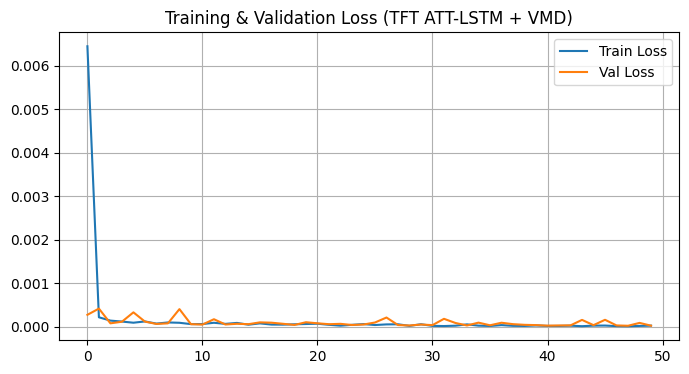

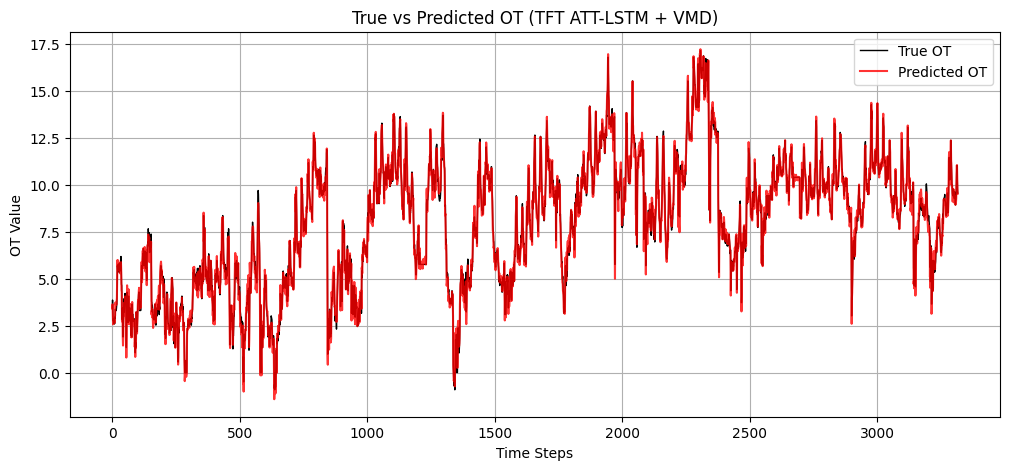

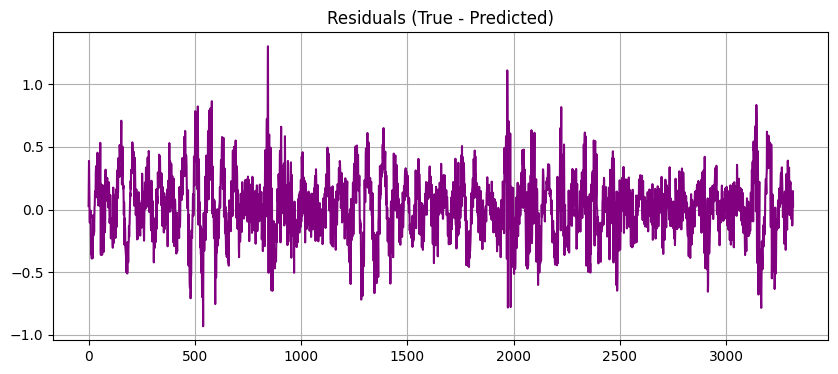

Total Area = 612.7811698904263
Area + = 341.561566730962
Area - = -271.2196031594643


In [10]:
checkpoint_cb = ModelCheckpoint(
    filepath="best_TFT_attlstm_vmd.keras",
    monitor="val_mse",      
    mode="min",
    save_best_only=True,
    verbose=1
)


model_build_TFTattlstm_model = build_TFTattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=60,
    lstm2_units=80,
    dense_units=64,
    num_heads=1,
    model_dim=64
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

# AttnLSTM+SIMPLE

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 168, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 168, 122)       │        60,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 168, 122)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau_3     │ (None, 122)            │        15,128 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 122)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 122)            │       119,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 122)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,137 (793.50 KB)

 Trainable params: 203,137 (793.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0076 - mae: 0.0614 - val_loss: 0.0029 - val_mae: 0.0433
Epoch 2/50
 11/431 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0038 - mae: 0.0468

/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_mse available.
  if self._should_save_model(epoch, batch, logs, filepath):


431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0047 - mae: 0.0527 - val_loss: 0.0028 - val_mae: 0.0427
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0045 - mae: 0.0515 - val_loss: 0.0035 - val_mae: 0.0468
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0042 - mae: 0.0504 - val_loss: 0.0031 - val_mae: 0.0448
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0043 - mae: 0.0508 - val_loss: 0.0032 - val_mae: 0.0450
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0043 - mae: 0.0506 - val_loss: 0.0029 - val_mae: 0.0427
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0044 - mae: 0.0508 - val_loss: 0.0028 - val_mae: 0.0422
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0042 - mae: 0.0500 - val_loss: 0.0029 - val_mae: 0.0431
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0042 - mae: 0.0497 - val_loss: 0.0028 - val_mae: 0.0422
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - los

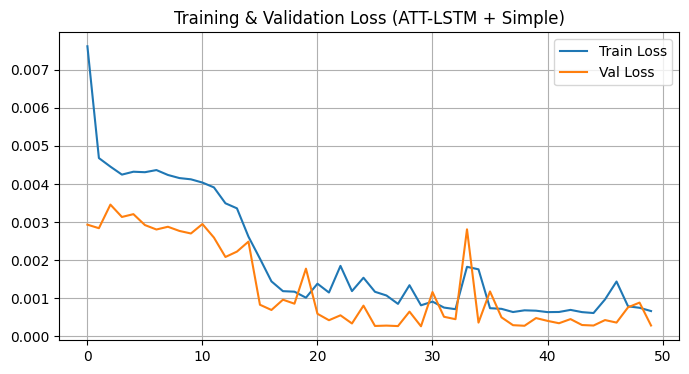

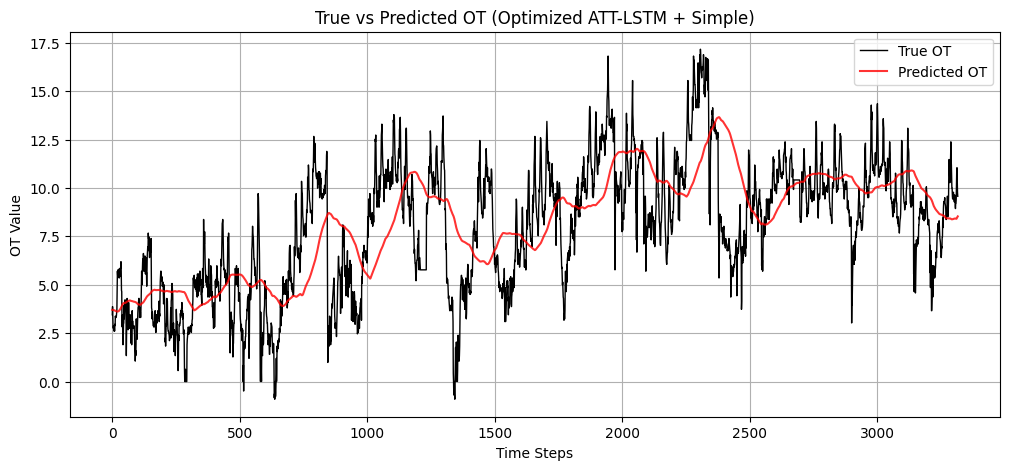

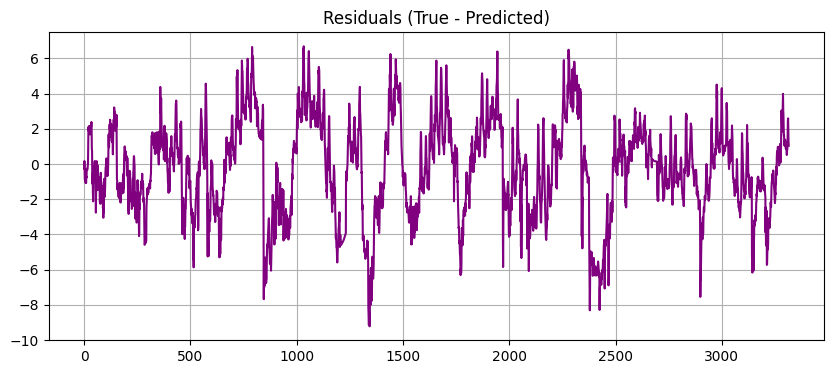

Total Area = 7187.070199638605
Area + = 3171.180556297303
Area - = -4015.889643341303


In [17]:
checkpoint_cb = ModelCheckpoint(
    filepath="best_attlstm_simple.keras",
    monitor="val_mse",      
    mode="min",
    save_best_only=True,
    verbose=1
)


model_build_attlstm_simple = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_simple.shape[-1]),
    lstm1_units=122,
    lstm2_units=122,
    dense_units=64
)

model_build_attlstm_simple.summary()

history_attlstm_simple = model_build_attlstm_simple.fit(
    X_train_simple, y_train_simple,
    validation_data=(X_test_simple, y_test_simple),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1
)

# Predict (inverse-transform from original OT scaling)
y_pred_attlstm_simple_ga_scaled = model_build_attlstm_simple.predict(X_test_simple)
y_pred_attlstm_simple_true = scaler_y.inverse_transform(y_pred_attlstm_simple_ga_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_simple.history['loss'], label='Train Loss')
plt.plot(history_attlstm_simple.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + Simple)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_simple_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_simple_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + Simple)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_simple_true - y_pred_attlstm_simple_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_simple_true.squeeze() - y_pred_attlstm_simple_true.squeeze()
area_total_attlstm_simple = np.trapezoid(np.abs(res))
print("Total Area =", area_total_attlstm_simple)
area_positive_attlstm_simple = np.trapezoid(np.clip(res, 0, None))
area_negative_attlstm_simple = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_attlstm_simple)
print("Area - =", area_negative_attlstm_simple)

# BidirectionalLSTM_SIMPLE

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 168, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 168, 200)       │        90,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 168, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,901 (823.83 KB)

 Trainable params: 210,901 (823.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0031 - mae: 0.0370 - val_loss: 3.7371e-04 - val_mae: 0.0143
Epoch 2/50
  7/431 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0013 - mae: 0.0280

/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_mse available.
  if self._should_save_model(epoch, batch, logs, filepath):


431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0013 - mae: 0.0268 - val_loss: 2.5803e-04 - val_mae: 0.0114
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0011 - mae: 0.0246 - val_loss: 6.0712e-04 - val_mae: 0.0208
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 9.1208e-04 - mae: 0.0226 - val_loss: 2.0742e-04 - val_mae: 0.0100
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 8.5524e-04 - mae: 0.0217 - val_loss: 2.0835e-04 - val_mae: 0.0100
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 7.8246e-04 - mae: 0.0206 - val_loss: 2.2104e-04 - val_mae: 0.0106
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 7.0519e-04 - mae: 0.0194 - val_loss: 2.0188e-04 - val_mae: 0.0099
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 6.8484e-04 - mae: 0.0191 - val_loss: 2.3116e-04 - val_mae: 0.0112
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 6.5415e-04 - mae: 0.0187 - val_loss: 2.5581e-04 - val_mae: 0.0122


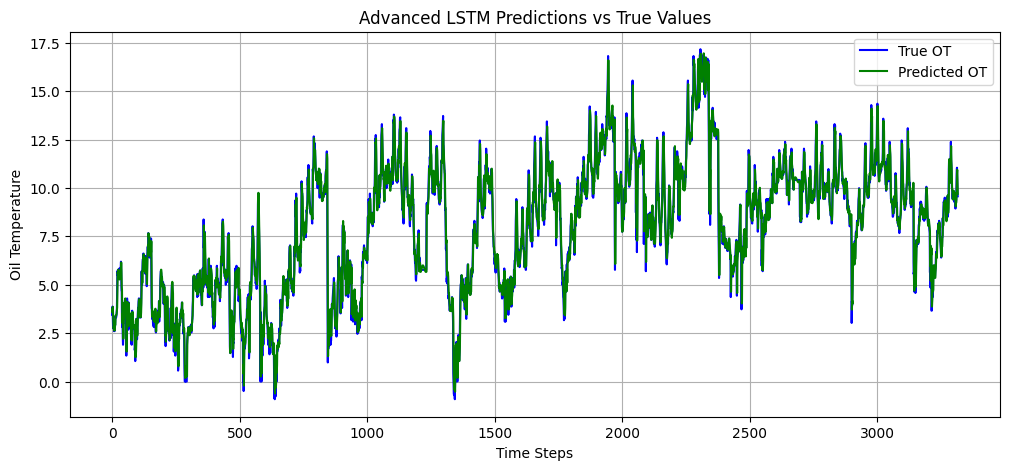

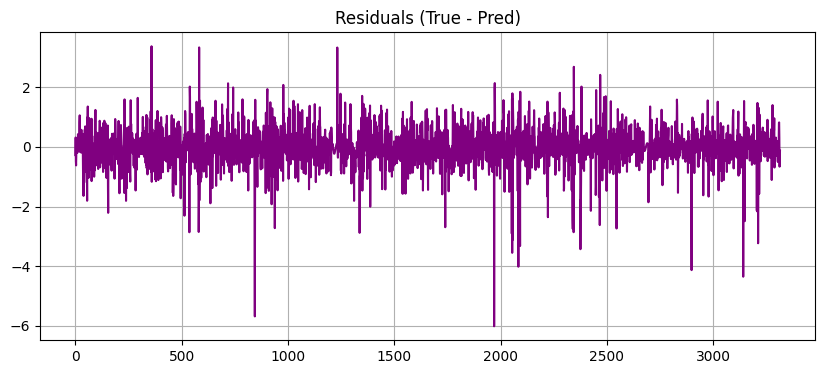

Total Area = 1449.5450246036053
Area + = 705.4426106959588
Area - = -744.1024139076465


In [16]:
checkpoint_cb = ModelCheckpoint(
    filepath="best_Bilstm_simple.keras",
    monitor="val_mse",      
    mode="min",
    save_best_only=True,
    verbose=1
)


def build_Bidirectional_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(units, return_sequences=True))(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

Bidirectional_lstm = build_Bidirectional_lstm_model((SEQ_LEN, K),100)
Bidirectional_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_Bidirectional_lstm_simple = Bidirectional_lstm.fit(
    X_train_simple, y_train_simple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple, y_test_simple),
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1
)

# Make predictions
y_pred_scaled_Bidirectional_lstm = Bidirectional_lstm.predict(X_test_simple)
y_pred_Bidirectional_lstm_simple_true = scaler_y.inverse_transform(y_pred_scaled_Bidirectional_lstm.reshape(-1, 1)).flatten()

# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT', color='blue')
plt.plot(y_pred_Bidirectional_lstm_simple_true, label='Predicted OT', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Advanced LSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_test_simple_true - y_pred_Bidirectional_lstm_simple_true.squeeze()
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

res = y_test_simple_true.squeeze() - y_pred_Bidirectional_lstm_simple_true
area_total_Bidirectional_lstm_simple = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Bidirectional_lstm_simple)
area_positive_Bidirectional_lstm_simple = np.trapezoid(np.clip(res, 0, None))
area_negative_Bidirectional_lstm_simple = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Bidirectional_lstm_simple)
print("Area - =", area_negative_Bidirectional_lstm_simple)

# LSTM_SIMPLE

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 168, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 168, 128)       │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,905 (796.50 KB)

 Trainable params: 203,905 (796.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0036 - mae: 0.0392 - val_loss: 4.8260e-04 - val_mae: 0.0162
Epoch 2/50
 10/431 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0014 - mae: 0.0285

/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_mse available.
  if self._should_save_model(epoch, batch, logs, filepath):


431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0014 - mae: 0.0279 - val_loss: 3.3158e-04 - val_mae: 0.0132
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 2.9477e-04 - val_mae: 0.0126
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 8.9474e-04 - mae: 0.0222 - val_loss: 2.6618e-04 - val_mae: 0.0121
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 7.9643e-04 - mae: 0.0211 - val_loss: 2.4017e-04 - val_mae: 0.0113
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 7.3981e-04 - mae: 0.0201 - val_loss: 1.9692e-04 - val_mae: 0.0098
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 6.5685e-04 - mae: 0.0189 - val_loss: 1.7732e-04 - val_mae: 0.0091
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 6.5197e-04 - mae: 0.0186 - val_loss: 2.0858e-04 - val_mae: 0.0104
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 6.2650e-04 - mae: 0.0181 - val_loss: 2.8064e-04 - val_mae: 0.0134
Epo

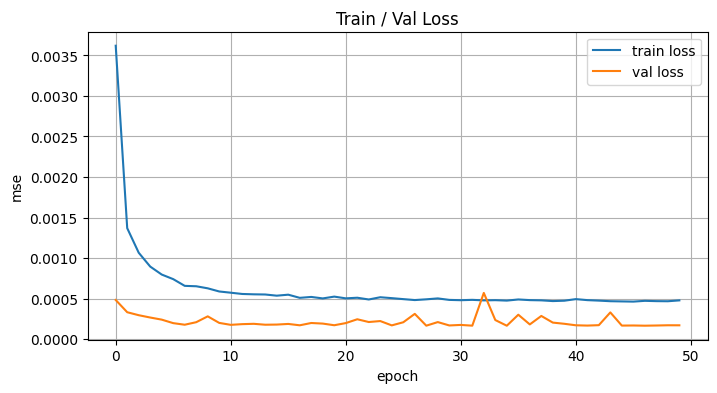

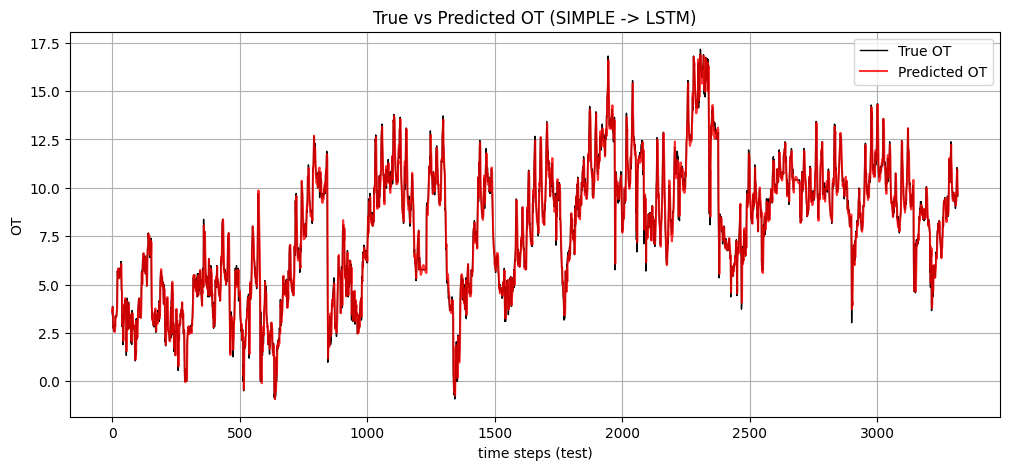

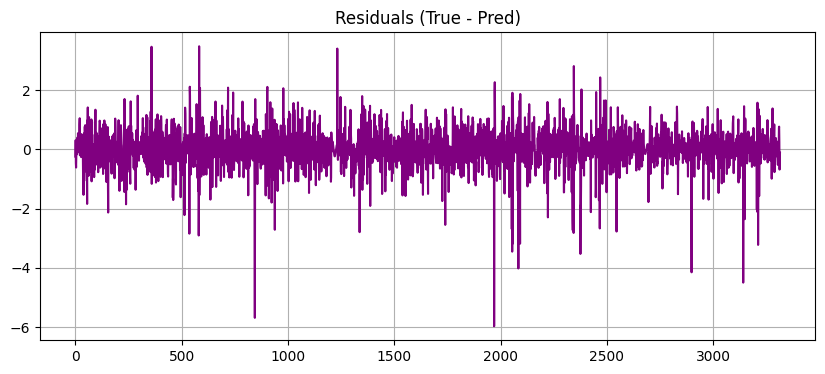

Total Area = 1450.7404817277566
Area + = 759.9448767211295
Area - = -690.795605006627


In [15]:
checkpoint_cb = ModelCheckpoint(
    filepath="best_lstm_simple.keras",
    monitor="val_mse",      
    mode="min",
    save_best_only=True,
    verbose=1
)


def build_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

model_lstm_model= build_lstm_model((SEQ_LEN, K),128)
model_lstm_model.summary()

# ---------------------------
# 6. Train
# ---------------------------
history_lstm_vmd = model_lstm_model.fit(
    X_train_simple, y_train_simple,
    validation_data=(X_test_simple, y_test_simple),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1
)
# ---------------------------
# 7. Predict & inverse-transform
# ---------------------------
y_pred_lstm_simple_scaled = model_lstm_model.predict(X_test_simple)
y_pred_lstm_simple_true = scaler_y.inverse_transform(y_pred_lstm_simple_scaled).flatten()

# ---------------------------
# 9. Plots
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history_lstm_vmd.history['loss'], label='train loss')
plt.plot(history_lstm_vmd.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('mse'); plt.legend(); plt.grid(True)
plt.title('Train / Val Loss')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_lstm_simple_true, label='Predicted OT', color='red', alpha=0.8)
plt.xlabel('time steps (test)')
plt.ylabel('OT')
plt.title('True vs Predicted OT (SIMPLE -> LSTM)')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_test_vmd_true.squeeze() - y_pred_lstm_simple_true.squeeze() 
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

res = y_test_vmd_true.squeeze() - y_pred_lstm_simple_true.squeeze()
area_total_lstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_lstm_vmd)
area_positive_lstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_lstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_lstm_vmd)
print("Area - =", area_negative_lstm_vmd)

# Compare Models

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_metrics(y_true, y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Compute metrics
mse_Attlstm_vmd, rmse_Attlstm_vmd, mae_Attlstm_vmd, r2_attlstm_vmd = compute_metrics(y_pred_attlstm_vmd_true, y_test_vmd_true)
mse_TAttlstm_vmd, rmse_TAttlstm_vmd, mae_TAttlstm_vmd, r2_Tattlstm_vmd = compute_metrics(y_pred_Tattlstm_vmd_true, y_test_vmd_true)
mse_TFTAttlstm_vmd, rmse_TFTAttlstm_vmd, mae_TFTAttlstm_vmd, r2_TFTattlstm_vmd = compute_metrics(y_pred_TFTattlstm_vmd_true, y_test_vmd_true)
mse_Lstm_Bidirectional_simple, rmse_Lstm_Bidirectional_simple, mae_Lstm_Bidirectional_simple, r2_Lstm_Bidirectional_simple = compute_metrics(y_pred_Bidirectional_lstm_simple_true, y_test_simple_true)
mse_Attlstm_simple, rmse_Attlstm_simple, mae_Attlstm_simple, r2_attlstm_simple = compute_metrics(y_pred_attlstm_simple_true, y_test_simple_true)
mse_Lstm_simple, rmse_Lstm_simple, mae_Lstm_simple, r2_Lstm_simple = compute_metrics(y_pred_lstm_simple_true, y_test_vmd_true)

# Print comparison
print("📈 Model Performance Comparison")
print(f"ATT-LSTM-VMD: MSE={mse_Attlstm_vmd:.4f}, RMSE={rmse_Attlstm_vmd:.4f}, MAE={mae_Attlstm_vmd:.4f}, R²={r2_attlstm_vmd:.4f}, total_area={area_total_attlstm_vmd:.4f}")
print(f"T ATT-LSTM-VMD: MSE={mse_TAttlstm_vmd:.4f}, RMSE={rmse_TAttlstm_vmd:.4f}, MAE={mae_TAttlstm_vmd:.4f}, R²={r2_Tattlstm_vmd:.4f}, total_area={area_total_Tattlstm_vmd:.4f}")
print(f"TFT ATT-LSTM-VMD: MSE={mse_TFTAttlstm_vmd:.4f}, RMSE={rmse_TFTAttlstm_vmd:.4f}, MAE={mae_TFTAttlstm_vmd:.4f}, R²={r2_TFTattlstm_vmd:.4f}, total_area={area_total_TFTattlstm_vmd:.4f}")
print(f"Bidirectional-Lstm_Simple: MSE={mse_Lstm_Bidirectional_simple:.4f}, RMSE={rmse_Lstm_Bidirectional_simple:.4f}, MAE={mae_Lstm_Bidirectional_simple:.4f}, R²={r2_Lstm_Bidirectional_simple:.4f}, total_area={area_total_Bidirectional_lstm_simple:.4f}")
print(f"ATT-LSTM_Simple: MSE={mse_Attlstm_simple:.4f}, RMSE={rmse_Attlstm_simple:.4f}, MAE={mae_Attlstm_simple:.4f}, R²={r2_attlstm_simple:.4f}, total_area={area_total_attlstm_simple:.4f}")
print(f"LSTM_simple: MSE={mse_Lstm_simple:.4f}, RMSE={rmse_Lstm_simple:.4f}, MAE={mae_Lstm_simple:.4f}, R²={r2_Lstm_simple:.4f}, total_area={area_total_lstm_vmd:.4f}")


📈 Model Performance Comparison
ATT-LSTM-VMD: MSE=0.1024, RMSE=0.3200, MAE=0.2489, R²=0.9903, total_area=825.1889
T ATT-LSTM-VMD: MSE=0.0935, RMSE=0.3058, MAE=0.2279, R²=0.9913, total_area=755.3798
TFT ATT-LSTM-VMD: MSE=0.0570, RMSE=0.2388, MAE=0.1848, R²=0.9950, total_area=612.7812
Bidirectional-Lstm_Simple: MSE=0.4142, RMSE=0.6436, MAE=0.4372, R²=0.9620, total_area=1449.5450
ATT-LSTM_Simple: MSE=7.3543, RMSE=2.7119, MAE=2.1676, R²=-0.1164, total_area=7187.0702
LSTM_simple: MSE=0.4141, RMSE=0.6435, MAE=0.4376, R²=0.9627, total_area=1450.7405


In [21]:
import pandas as pd

results = [
    ["AttLSTM + VMD", 
     mse_Attlstm_vmd, rmse_Attlstm_vmd, mae_Attlstm_vmd, r2_attlstm_vmd, area_total_attlstm_vmd],

    ["T-AttLSTM + VMD", 
     mse_TAttlstm_vmd, rmse_TAttlstm_vmd, mae_TAttlstm_vmd, r2_Tattlstm_vmd, area_total_Tattlstm_vmd],

    ["TFT-AttLSTM + VMD", 
     mse_TFTAttlstm_vmd, rmse_TFTAttlstm_vmd, mae_TFTAttlstm_vmd, r2_TFTattlstm_vmd, area_total_TFTattlstm_vmd],

    ["BiLSTM (Simple)", 
     mse_Lstm_Bidirectional_simple, rmse_Lstm_Bidirectional_simple,
     mae_Lstm_Bidirectional_simple, r2_Lstm_Bidirectional_simple,
     area_total_Bidirectional_lstm_simple],

    ["AttLSTM (Simple)", 
     mse_Attlstm_simple, rmse_Attlstm_simple, mae_Attlstm_simple,
     r2_attlstm_simple, area_total_attlstm_simple],

    ["LSTM (Simple)", 
     mse_Lstm_simple, rmse_Lstm_simple, mae_Lstm_simple,
     r2_Lstm_simple, area_total_lstm_vmd],
]

df_results = pd.DataFrame(
    results,
    columns=["Model(7days)", "MSE ↓", "RMSE ↓", "MAE ↓", "R² ↑", "Total Area ↓"]
)

# Sort by MAE (primary metric)
df_results = df_results.sort_values("MAE ↓").reset_index(drop=True)

df_results


,Model(7days),MSE ↓,RMSE ↓,MAE ↓,R² ↑,Total Area ↓
0,TFT-AttLSTM + VMD,0.057027,0.238803,0.184803,0.994965,612.781170
1,T-AttLSTM + VMD,0.093499,0.305776,0.227856,0.991280,755.379815
2,AttLSTM + VMD,0.102372,0.319956,0.248854,0.990283,825.188934
3,BiLSTM (Simple),0.414215,0.643595,0.437198,0.962010,1449.545025
4,LSTM (Simple),0.414050,0.643467,0.437550,0.962709,1450.740482
5,AttLSTM (Simple),7.354269,2.711876,2.167586,-0.116447,7187.070200


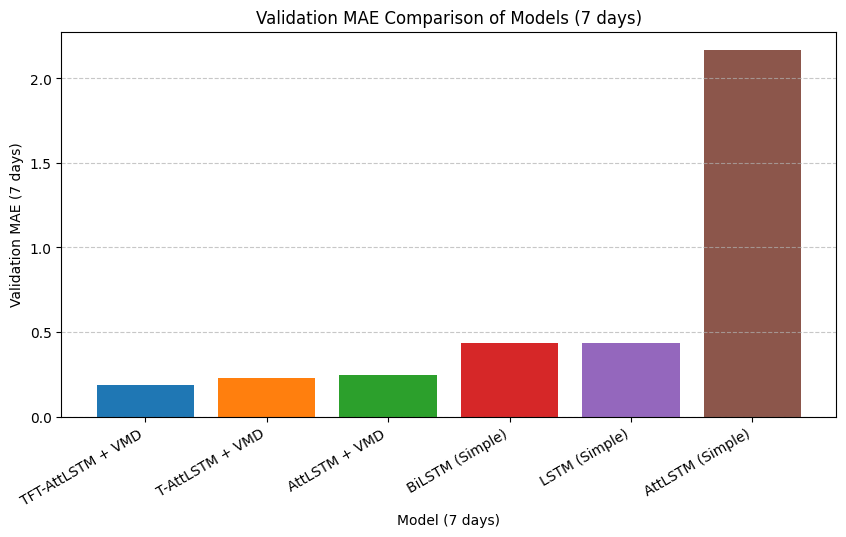

In [22]:
from docx import Document
from docx.shared import Inches

# Create Word document
doc = Document()
doc.add_heading('Model Performance Comparison_7days', level=1)

# Add table
table = doc.add_table(rows=1, cols=6)
table.style = 'Table Grid'

# Header row
hdr_cells = table.rows[0].cells
headers = ["Model(7days)", "MSE ↓", "RMSE ↓", "MAE ↓", "R² ↑", "Total Area ↓"]

for i, header in enumerate(headers):
    hdr_cells[i].text = header

# Add data rows
for _, row in df_results.iterrows():
    row_cells = table.add_row().cells
    row_cells[0].text = row["Model(7days)"]
    row_cells[1].text = f"{row['MSE ↓']:.4f}"
    row_cells[2].text = f"{row['RMSE ↓']:.4f}"
    row_cells[3].text = f"{row['MAE ↓']:.4f}"
    row_cells[4].text = f"{row['R² ↑']:.4f}"
    row_cells[5].text = f"{row['Total Area ↓']:.4f}"

# Save document
doc.save("Model_Performance_Comparison_7days.docx")

import matplotlib.pyplot as plt

# Extract data
models = df_results["Model(7days)"]
mae_values = df_results["MAE ↓"]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

colors = plt.cm.tab10(range(len(models)))  # distinct colors
plt.bar(models, mae_values, color=colors)

plt.ylabel("Validation MAE (7 days)")
plt.xlabel("Model (7 days)")
plt.title("Validation MAE Comparison of Models (7 days)")

plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig(
    "val_mae_comparison(7days).png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()



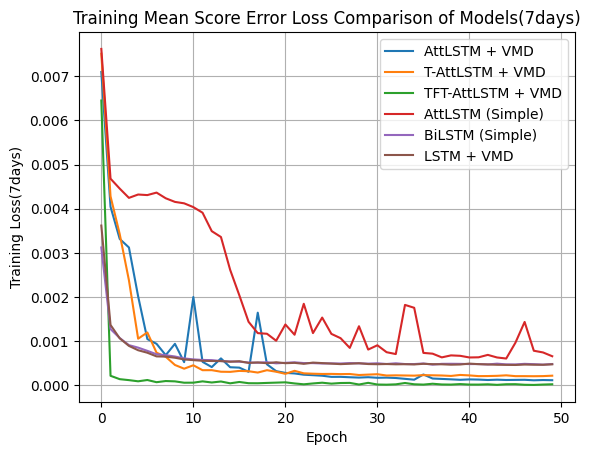

In [23]:
import matplotlib.pyplot as plt

plt.plot(history_attlstm_vmd.history["loss"], label="AttLSTM + VMD")
plt.plot(history_Tattlstm_vmd.history["loss"], label="T-AttLSTM + VMD")
plt.plot(history_TFTattlstm_vmd.history["loss"], label="TFT-AttLSTM + VMD")
plt.plot(history_attlstm_simple.history["loss"], label="AttLSTM (Simple)")
plt.plot(history_Bidirectional_lstm_simple.history["loss"], label="BiLSTM (Simple)")
plt.plot(history_lstm_vmd.history["loss"], label="LSTM + VMD")

plt.xlabel("Epoch")
plt.ylabel("Training Loss(7days)")
plt.title("Training Mean Score Error Loss Comparison of Models(7days)")
plt.legend()
plt.grid(True)
# ✅ Save figure (300 DPI, PNG)
plt.savefig(
    "training_loss_comparison(7days).png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()
